In [86]:
import math
import numpy as np
import pandas as pd
from numba import vectorize
import matplotlib.pyplot as plt
import json

# Process
1. determine the section properties of the cross section
2. find the position with the highest normal stress and place a stringer there
3. rinse and repeat until we've found 7 stringers

# Parameterization

In [87]:
stringer_step = 1 / 4
outside_len = 8

t = np.arange(start=0, stop=outside_len, step=stringer_step)


@vectorize(nopython=True)
def pos_y_top(t):
    return 15 * math.cos(0.066865794705 * t + 1.43706473738) + 2


@vectorize(nopython=True)
def pos_z_top(t):
    return 15 * math.sin(0.066865794705 * t + 1.43706473738) - 13.6160687473


@vectorize(nopython=True)
def pos_y_bot(t):
    return t


@vectorize(nopython=True)
def pos_z_bot(t):
    return t / 8


@vectorize(nopython=True)
def pos_y_front(t):
    return 0


@vectorize(nopython=True)
def pos_z_front(t):
    return -t + 1.25


@vectorize(nopython=True)
def pos_y_rear(t):
    return 4


@vectorize(nopython=True)
def pos_z_rear(t):
    return 0.5 + t


@vectorize(nopython=True)
def pos_y(t):
    if t < 4:
        return pos_y_top(t)
    else:
        return pos_y_bot(t - 4)


@vectorize(nopython=True)
def pos_z(t):
    if t < 4:
        return pos_z_top(t)
    else:
        return pos_z_bot(t - 4)


@vectorize(nopython=True)
def thickness(t):
    return 1 / 32


@vectorize(nopython=True)
def mod_elastic(t):
    return 2036e3


points = np.array((pos_y(t), pos_z(t), thickness(t), mod_elastic(t)))

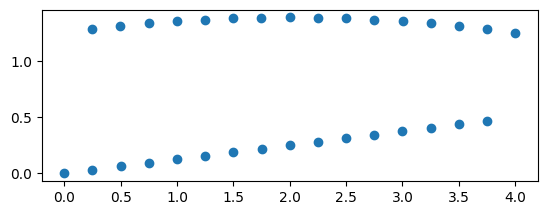

In [88]:
plt.scatter(points[0], points[1])
ax = plt.gca()
ax.set_aspect("equal")

# Stress equations

In [89]:
@vectorize(nopython=True)
def shear_flow(load, y_bar):
    M_x = load * (2 - y_bar) - 5 * (1 - y_bar)
    q = M_x / (2 * 4.136)
    return q


@vectorize(nopython=True)
def shear_stress(load, y_bar, thickness):
    q = shear_flow(load, y_bar)
    return q / thickness


@vectorize(
    nopython=True,
)
def normal_stress(
    load,
    x,
    y,
    z,
    i_yy,
    i_zz,
    i_yz,
    mod_elastic,
):
    return mod_elastic * (
        -y * ((load - 5) * (x - 45.75) * i_yz / (i_yy * i_zz - i_yz**2))
        + z * ((load - 5) * (x - 45.75) * i_zz / (i_yy * i_zz - i_yz**2))
    )

# Section Properties

In [90]:
def section_properties(stringer_positions):
    shape = (4 + stringer_positions.shape[0], stringer_positions.shape[1])
    area = np.zeros(shape)
    y = np.zeros(shape)
    z = np.zeros(shape)
    i_yy = np.zeros(shape)
    i_zz = np.zeros(shape)
    i_yz = np.zeros(shape)
    mod_elastic = np.zeros(shape)

    # Seed 4 parts that are always there
    ## rear spar
    area[0] = 0.09375
    y[0] = 3.9375
    z[0] = 0.875
    i_yy[0] = 0.00439453125
    i_zz[0] = 0.0001220703125  # Izz*
    i_yz[0] = 0.0
    mod_elastic[0] = 1926.0e3  # modulus of elasticity

    ## top skin
    area[1] = 0.12525
    y[1] = 2
    z[1] = 1.354
    i_yy[1] = 0.0007491
    i_zz[1] = 0.16706
    i_yz[1] = 0
    mod_elastic[1] = 2036e3

    ## front spar
    area[2] = 0.15625
    y[2] = 0.0625
    z[2] = 0.625
    i_yy[2] = 0.02034505208
    i_zz[2] = 0.0002034505208
    i_yz[2] = 0
    mod_elastic[2] = 1926e3

    ## bottom skin
    area[3] = 0.12597
    y[3] = 2
    z[3] = 0.23438
    i_yy[3] = 0.00263426
    i_zz[3] = 0.16796
    i_yz[3] = 0.0209929
    mod_elastic[3] = 2036e3

    # Stringer properties
    area[4:] = 0.015625
    i_yy[4:] = 0.0000203451
    i_zz[4:] = 0.0000203451
    mod_elastic[4:] = 2.010e6

    for i in range(stringer_positions.shape[0]):
        y[4 + i] = pos_y(stringer_positions[i])
        z[4 + i] = pos_z(stringer_positions[i])

    y_bar_tot = np.sum(mod_elastic * area * y) / np.sum(mod_elastic * area)
    z_bar_tot = np.sum(mod_elastic * area * z) / np.sum(mod_elastic * area)
    i_yy_tot = np.sum(mod_elastic * (i_yy + area * (z - z_bar_tot) ** 2))
    i_zz_tot = np.sum(mod_elastic * (i_zz + area * (y - y_bar_tot) ** 2))
    i_yz_tot = np.sum(mod_elastic * (i_yz + area * (y - y_bar_tot) * (z - z_bar_tot)))
    return (y_bar_tot, z_bar_tot, i_yy_tot, i_zz_tot, i_yz_tot)

In [91]:
stringers = []
for i in range(7):
    stringer_positions = np.array([[pos, *stringers] for pos in t]).T
    (y_bar, z_bar, i_yy, i_zz, i_yz) = section_properties(stringer_positions)
    norm_stress = normal_stress(
        50, 0, points[0] - y_bar, points[1] - z_bar, i_yy, i_zz, i_yz, points[3]
    )
    sorted_indices = np.flip(np.argsort(abs(norm_stress)))
    loc = -1
    for i in sorted_indices:
        if stringer_positions[0, i] not in stringers:
            stringers = stringer_positions[:, i]
            break

(y_bar, z_bar, i_yy, i_zz, i_yz) = section_properties(np.array([stringers]))

print(
    "t (parametric distance): ",
    json.dumps(stringers.tolist()),
    "\n",
    "y (in): ",
    json.dumps(pos_y(stringers).tolist()),
    "\n",
    "z (in): ",
    json.dumps(pos_z(stringers).tolist()),
    "\n",
    f"y_bar: {float(y_bar)}\n",
    f"z_bar: {float(z_bar)}\n",
    f"i_yy: {float(i_yy)}\n",
    f"i_zz: {float(i_zz)}\n",
    f"i_yz: {float(i_yz)}\n",
)

t (parametric distance):  [4.5, 2.75, 3.5, 4.25, 3.25, 4.0, 3.0] 
 y (in):  [0.5, 1.248075078605556, 0.49804081961796953, 0.25, 0.747725601630417, 0.0, 0.9977603106216619] 
 z (in):  [0.0625, 1.3650730286991166, 1.3085457743707725, 0.03125, 1.3315668125866562, 0.0, 1.3504109859250057] 
 y_bar: 1.729586763293556
 z_bar: 0.7574477019202167
 i_yy: 1655201.1543953293
 i_zz: 17369447.705220174
 i_yz: 1166281.9494033027



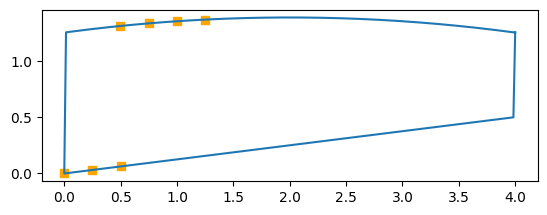

In [92]:
t = np.arange(0, 8, 1 / 64)

y = pos_y(t)
z = pos_z(t)

plt.plot([*y, y[0]], [*z, z[0]])
plt.scatter(pos_y(stringers), pos_z(stringers), color="orange", marker="s")
ax = plt.gca()
ax.set_aspect("equal")

# Predictions
- Failure load
- 15 deflection
- Q deflection

In [93]:
t = np.arange(0, 10, step=1 / 32)


@vectorize(nopython=True)
def pos_y(t):
    if t < 4:
        return pos_y_top(t)
    elif t < 4 + 1.25:
        return pos_y_front(t - 4)
    elif t < 4 + 1.25 + 4:
        return pos_y_bot(t - (4 + 1.25))
    else:
        return pos_y_rear(t - (4 + 1.25 + 4))


@vectorize(nopython=True)
def pos_z(t):
    if t < 4:
        return pos_z_top(t)
    elif t < 4 + 1.25:
        return pos_z_front(t - 4)
    elif t < 4 + 1.25 + 4:
        return pos_z_bot(t - (4 + 1.25))
    else:
        return pos_z_rear(t - (4 + 1.25 + 4))


@vectorize(nopython=True)
def mod_elastic(t):
    if t < 4:
        return 2036e3
    elif t < 4 + 1.25:
        return 1926e3
    elif t < 4 + 1.25 + 4:
        return 2036e3
    else:
        return 1926e3


@vectorize(nopython=True)
def thickness(t):
    if t < 4:
        return 1 / 32
    elif t < 4 + 1.25:
        return 1 / 8
    elif t < 4 + 1.25 + 4:
        return 1 / 32
    else:
        return 1 / 8


points = np.array([pos_y(t), pos_z(t), mod_elastic(t), thickness(t)])

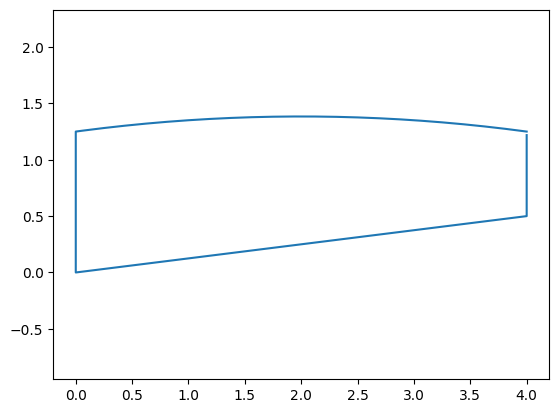

In [94]:
fig, ax = plt.subplots()
_ = ax.axis("equal")
_ = ax.plot(points[0], points[1])

# Failure criterion

In [95]:
@vectorize(nopython=True)
def failed(x, y, z, mod_elastic, load, i_yy, i_zz, i_yz, y_bar, z_bar, thickness):
    shear = np.abs(shear_stress(load, y_bar, thickness)) / 1000
    normal = (
        np.abs(
            normal_stress(load, x, y - y_bar, z - z_bar, i_yy, i_zz, i_yz, mod_elastic)
        )
        / 1000
    )

    # 1/8
    f_1 = -0.038
    f_11 = 0.0096
    f_66 = 0.44

    # 1/16
    if thickness < 1 / 8:
        f_1 = -0.054
        f_11 = 0.0072

    # 1/32
    if thickness < 1 / 16:
        f_1 = -0.048
        f_11 = 0.0078
        f_66 = 0.31

    failed = f_1 * normal + f_11 * normal**2 + f_66 * shear**2 >= 1

    return failed

In [96]:
min_load = 0
max_load = 1000
for i in range(20):
    load = (min_load + max_load) / 2
    did_fail = failed(
        0,
        points[0],
        points[1],
        points[2],
        load,
        i_yy,
        i_zz,
        i_yz,
        y_bar,
        z_bar,
        points[3],
    )

    if np.any(did_fail):
        max_load = load
    else:
        min_load = load
print(load)

367.3868179321289


In [97]:
@vectorize(nopython=True)
def deflection_y(i_yy, i_zz, i_yz, load):
    i_til = i_yy * i_zz - i_yz**2
    return (load - 5) * (46**3 / 6 - 22.875 * 46**2) * i_yz / i_til


@vectorize(nopython=True)
def deflection_z(i_yy, i_zz, i_yz, load):
    i_til = i_yy * i_zz - i_yz**2
    return (load - 5) * (46**3 / 6 - 22.875 * 46**2) * i_zz / i_til


@vectorize(nopython=True)
def twist(load, y_bar):
    q = shear_flow(load, y_bar)
    return 4.43525e-6 * q**2 + 0.0334937 * q

In [98]:
y_def_15 = deflection_y(i_yy, i_zz, i_yz, 15)
z_def_15 = deflection_z(i_yy, i_zz, i_yz, 15)
twist_15 = twist(15, y_bar)
y_def_q = deflection_y(i_yy, i_zz, i_yz, 0)
z_def_q = deflection_z(i_yy, i_zz, i_yz, 0)
twist_q = twist(0, y_bar)
print(
    f"y deflection with Q only: {y_def_q:.5} in\n"
    f"z deflection with Q only: {z_def_q:.5} in\n"
    f"twist with Q only: {twist_q:.5} rad\n"
    f"y deflection at 15lb: {y_def_15:.5} in\n"
    f"z deflection at 15lb: {z_def_15:.5} in\n"
    f"twist at 15 lb: {twist_15:.5} rad\n"
)

y deflection with Q only: 0.0068515 in
z deflection with Q only: 0.10204 in
twist with Q only: 0.014772 rad
y deflection at 15lb: -0.013703 in
z deflection at 15lb: -0.20408 in
twist at 15 lb: 0.031198 rad

